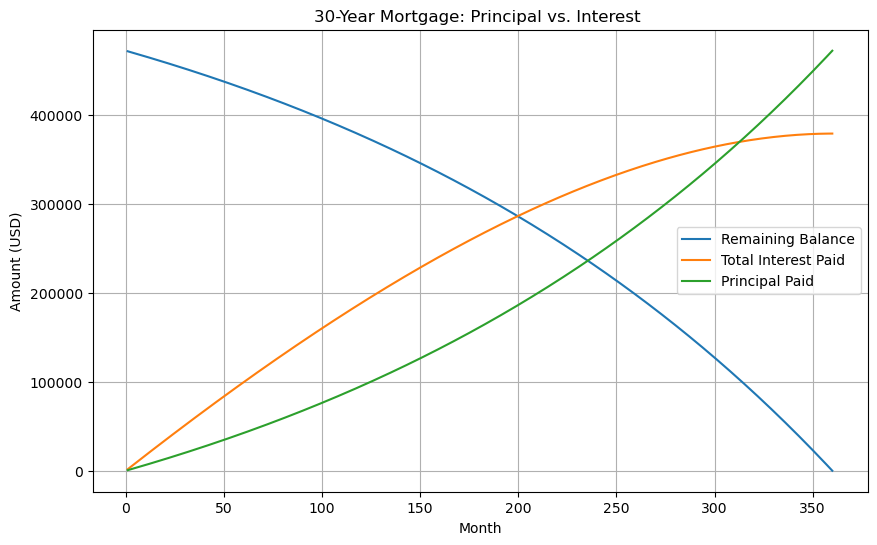

Monthly Payment: $2366.10
Total Interest Paid over 30 years: $379294.31


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
principal = 472500  # 贷款本金（美元）
annual_rate = 4.4 / 100  # 年利率
years = 30  # 贷款年限
months = years * 12  # 总月数
monthly_rate = annual_rate / 12  # 月利率

# 每月还款额公式 (等额本息)
# M = P * r * (1+r)**n / ((1+r)**n - 1)
M = principal  * monthly_rate * (1 + monthly_rate)**months / ((1 + monthly_rate)**months-1)

# 初始化数组
remaining_balance = []
interest_paid = []
principal_paid = []
total_interest = 0
balance = principal

for i in range(1, months + 1):
    interest = balance * monthly_rate   # 当月利息
    principal_payment = M - interest    # 当月本金
    balance -= principal_payment        # 剩余本金
    total_interest += interest          # 累计利息

    remaining_balance.append(balance if balance > 0 else 0)
    interest_paid.append(total_interest)
    principal_paid.append(principal - balance)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(range(1, months + 1), remaining_balance, label="Remaining Balance")
plt.plot(range(1, months + 1), interest_paid, label="Total Interest Paid")
plt.plot(range(1, months + 1), principal_paid, label="Principal Paid")
plt.xlabel("Month")
plt.ylabel("Amount (USD)")
plt.title("30-Year Mortgage: Principal vs. Interest ")
plt.legend()
plt.grid(True)
plt.show()

print(f"Monthly Payment: ${M:.2f}")
print(f"Total Interest Paid over {years} years: ${total_interest:.2f}")


In [10]:
# 参数
P = 472500         # 本金
annual_rate = 4.375 # 年利率 %
r = annual_rate/100/12  # 月利率
n = 30*12          # 30年 * 12月

# 等额本息公式
M = P * r * (1+r)**n / ((1+r)**n - 1)

print(f"每月还款额: ${M:.2f}")


每月还款额: $2359.12


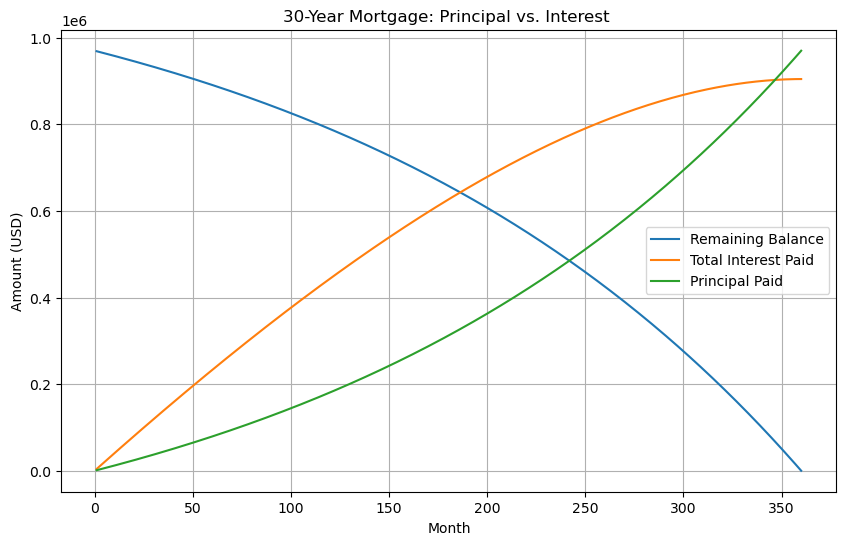

Monthly Payment: $5207.17
Total Interest Paid over 30 years: $904581.11


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
principal = 970000  # 贷款本金（美元）
annual_rate = 5 / 100  # 年利率
years = 30  # 贷款年限
months = years * 12  # 总月数
monthly_rate = annual_rate / 12  # 月利率

# 每月还款额公式 (等额本息)
# M = P * r * (1+r)**n / ((1+r)**n - 1)
M = principal  * monthly_rate * (1 + monthly_rate)**months / ((1 + monthly_rate)**months-1)

# 初始化数组
remaining_balance = []
interest_paid = []
principal_paid = []
total_interest = 0
balance = principal

for i in range(1, months + 1):
    interest = balance * monthly_rate   # 当月利息
    principal_payment = M - interest    # 当月本金
    balance -= principal_payment        # 剩余本金
    total_interest += interest          # 累计利息

    remaining_balance.append(balance if balance > 0 else 0)
    interest_paid.append(total_interest)
    principal_paid.append(principal - balance)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(range(1, months + 1), remaining_balance, label="Remaining Balance")
plt.plot(range(1, months + 1), interest_paid, label="Total Interest Paid")
plt.plot(range(1, months + 1), principal_paid, label="Principal Paid")
plt.xlabel("Month")
plt.ylabel("Amount (USD)")
plt.title("30-Year Mortgage: Principal vs. Interest ")
plt.legend()
plt.grid(True)
plt.show()

print(f"Monthly Payment: ${M:.2f}")
print(f"Total Interest Paid over {years} years: ${total_interest:.2f}")


=== SSA Estimate - Summary ===
{'Assumed AIME ($/mo)': 14050.0, 'PIA at FRA ($/mo)': 3991.68, 'FRA (years)': 67.0, 'Taxable Max Used ($/yr)': 168600.0, 'Bend1 ($/mo)': 1174.0, 'Bend2 ($/mo)': 7078.0}

=== SSA Estimate - Monthly Benefit by Claim Age ===
 Claim Age  Adjustment Factor  Monthly Benefit ($)  Annual Benefit ($)
        62             0.7000              2794.18            33530.11
        63             0.7500              2993.76            35925.12
        64             0.8000              3193.34            38320.13
        65             0.8667              3459.46            41513.47
        66             0.9333              3725.57            44706.82
        67             1.0000              3991.68            47900.16
        68             1.0800              4311.01            51732.17
        69             1.1600              4630.35            55564.19
        70             1.2400              4949.68            59396.20


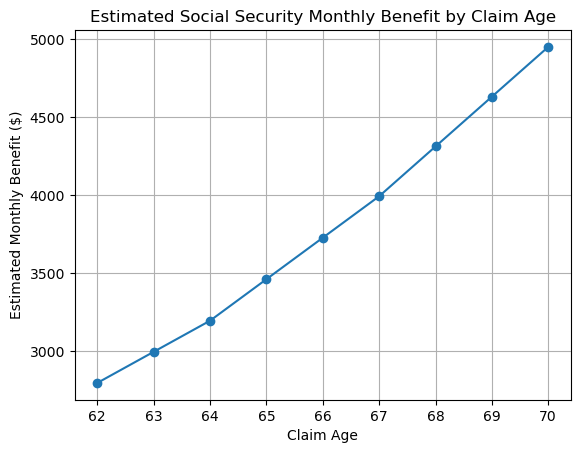

In [24]:
# ssa_estimator.py
# Social Security Retirement Benefit Estimator (simplified, configurable)
# Assumptions:
# - Bend points默认使用 2024/2025 附近水平（bend1=1174, bend2=7078）；每年会变，按需更新。
# - Taxable_max 默认 168,600（2024 社保应税工资上限）；每年会变，按需更新。
# - 这里把传入的年薪当作“已指数化”的工资（简化），实际 SSA 会做工资指数化。
# - 申领年龄调整使用 SSA 的月度精确规则：提前（5/9% 与 5/12%），递延（2/3%）。

from dataclasses import dataclass
from typing import List
import math
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class SSParams:
    bend1: float = 1174.0          # 第一折点（$/月）
    bend2: float = 7078.0          # 第二折点（$/月）
    taxable_max: float = 168_600.0 # 社保应税工资上限（$/年）
    fra_age_years: int = 67        # 完全退休年龄（年）
    fra_age_months: int = 0        # 完全退休年龄（额外月份）

def compute_aime_from_salaries(salaries: List[float], taxable_max: float) -> float:
    """
    由工资序列计算 AIME（平均指数化月收入）。
    - 对每年的工资按 taxable_max 截断。
    - 取最高的 35 年；不足 35 年用 0 补齐（会拉低 AIME）。
    - 将 35 年总额除以 420（月）得到 AIME（$/月）。
    """
    capped = [min(s, taxable_max) for s in salaries]
    capped_sorted = sorted(capped, reverse=True)[:35]
    if len(capped_sorted) < 35:
        capped_sorted += [0.0] * (35 - len(capped_sorted))
    aime = sum(capped_sorted) / (35 * 12)
    return aime

def compute_pia(aime: float, params: SSParams) -> float:
    """
    根据 bend points 计算 PIA（主要保险金额），单位：$/月。
    PIA = 90% * (0~bend1) + 32% * (bend1~bend2) + 15% * (bend2~∞) 的 AIME 分段之和。
    """
    b1, b2 = params.bend1, params.bend2
    part1 = 0.90 * min(aime, b1)
    part2 = 0.32 * max(0.0, min(aime, b2) - b1)
    part3 = 0.15 * max(0.0, aime - b2)
    return part1 + part2 + part3

def fra_in_months(params: SSParams) -> int:
    return params.fra_age_years * 12 + params.fra_age_months

def claiming_adjustment_factor(claim_age_years: int, claim_age_months: int, params: SSParams) -> float:
    """
    申领年龄相对 FRA 的调整因子：
      - 提前领取（FRA 前）：
          前 36 个月：每月减 5/9%（≈0.5556%）
          超过 36 个月：每月减 5/12%（≈0.4167%）
      - 延迟领取（FRA 后至 70 岁）：每月加 2/3%（≈0.6667%）
    返回：乘在 PIA 上的系数。
    """
    fra_m = fra_in_months(params)
    claim_m = claim_age_years * 12 + claim_age_months
    diff = claim_m - fra_m

    if diff == 0:
        return 1.0
    elif diff < 0:
        months_early = -diff
        first_36 = min(months_early, 36)
        extra = max(0, months_early - 36)
        reduction = first_36 * (5/9/100) + extra * (5/12/100)
        return max(0.0, 1.0 - reduction)
    else:
        # 延迟领取，上限 70 岁
        max_m = 70 * 12
        eligible_m = min(claim_m, max_m) - fra_m
        if eligible_m <= 0:
            return 1.0
        increase = eligible_m * (2/3/100)
        return 1.0 + increase

def benefit_by_claiming_age(pia: float, params: SSParams, start_age: int = 62, end_age: int = 70) -> pd.DataFrame:
    """
    生成 [start_age, end_age] 每个整岁申领时的月/年金额表。
    """
    rows = []
    for age in range(start_age, end_age + 1):
        factor = claiming_adjustment_factor(age, 0, params)
        monthly = pia * factor
        rows.append({
            "Claim Age": age,
            "Adjustment Factor": round(factor, 4),
            "Monthly Benefit ($)": round(monthly, 2),
            "Annual Benefit ($)": round(monthly * 12, 2),
        })
    return pd.DataFrame(rows)

def demo_run():
    """
    示例：35 年、平均年薪 180,000 美元（逐年相同），FRA=67。
    注意：实际社保只计到每年 taxable_max（默认 168,600）。
    """
    params = SSParams(
        bend1=1174.0,
        bend2=7078.0,
        taxable_max=168_600.0,  # 如需更贴近最新年份，请更新
        fra_age_years=67,
        fra_age_months=0
    )

    years_worked = 35
    avg_salary = 180_000.0
    salaries = [avg_salary] * years_worked

    aime = compute_aime_from_salaries(salaries, params.taxable_max)
    pia = compute_pia(aime, params)

    print("=== SSA Estimate - Summary ===")
    print({
        "Assumed AIME ($/mo)": round(aime, 2),
        "PIA at FRA ($/mo)": round(pia, 2),
        "FRA (years)": params.fra_age_years + params.fra_age_months/12,
        "Taxable Max Used ($/yr)": params.taxable_max,
        "Bend1 ($/mo)": params.bend1,
        "Bend2 ($/mo)": params.bend2
    })

    df = benefit_by_claiming_age(pia, params, 62, 70)
    print("\n=== SSA Estimate - Monthly Benefit by Claim Age ===")
    print(df.to_string(index=False))

    # 可视化：申领年龄 vs 月领金额
    plt.figure()
    plt.plot(df["Claim Age"], df["Monthly Benefit ($)"], marker='o')
    plt.xlabel("Claim Age")
    plt.ylabel("Estimated Monthly Benefit ($)")
    plt.title("Estimated Social Security Monthly Benefit by Claim Age")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    demo_run()


=== Lifetime totals if death at 78 (undiscounted unless you set a rate) ===
 Claim Age  Monthly at Claim ($)  Lifetime Total ($)
        62               2794.18           704132.35
        63               2993.76           718502.40
        64               3193.34           728082.43
        65               3459.46           747242.50
        66               3725.57           760015.87
        67               3991.68           766402.56
        68               4311.01           775982.59
        69               4630.35           777898.60
        70               4949.68           772150.58


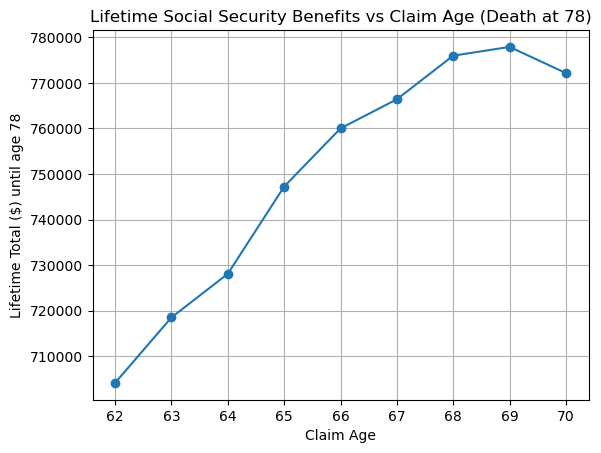

In [31]:
# ssa_lifetime_78.py
# 计算：若寿命固定到 78 岁，不同申领年龄的一生总领取金额 + 曲线
# 说明：
# - Bend points、税基上限(taxable_max)可按年份更新。
# - 默认不考虑COLA与贴现；可在参数里开启。
# - 工资序列 salaries 可替换为你的逐年工资（长度不限），脚本会自动按社保税基上限截断并取最高35年。

from dataclasses import dataclass
from typing import List
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class SSParams:
    bend1: float = 1174.0           # 第一折点（$/月）——更新为当前年份更准确
    bend2: float = 7078.0           # 第二折点（$/月）
    taxable_max: float = 168_600.0  # 社保应税工资上限（$/年）
    fra_age_years: int = 67         # 完全退休年龄（年）
    fra_age_months: int = 0         # 完全退休年龄（额外月份）

# ===== 基础函数 =====
def compute_aime_from_salaries(salaries: List[float], taxable_max: float) -> float:
    capped = [min(s, taxable_max) for s in salaries]
    capped_sorted = sorted(capped, reverse=True)[:35]
    if len(capped_sorted) < 35:
        capped_sorted += [0.0] * (35 - len(capped_sorted))
    return sum(capped_sorted) / (35 * 12)

def compute_pia(aime: float, p: SSParams) -> float:
    part1 = 0.90 * min(aime, p.bend1)
    part2 = 0.32 * max(0.0, min(aime, p.bend2) - p.bend1)
    part3 = 0.15 * max(0.0, aime - p.bend2)
    return part1 + part2 + part3

def fra_in_months(p: SSParams) -> int:
    return p.fra_age_years * 12 + p.fra_age_months

def claiming_adjustment_factor(claim_age_years: int, claim_age_months: int, p: SSParams) -> float:
    """
    提前：前36个月每月减 5/9%，超过部分每月减 5/12%
    延迟：FRA后到70岁每月加 2/3%
    """
    fra_m = fra_in_months(p)
    claim_m = claim_age_years * 12 + claim_age_months
    diff = claim_m - fra_m

    if diff == 0:
        return 1.0
    if diff < 0:
        months_early = -diff
        first_36 = min(months_early, 36)
        extra = max(0, months_early - 36)
        reduction = first_36 * (5/9/100) + extra * (5/12/100)
        return max(0.0, 1.0 - reduction)
    # 延迟
    max_m = 70 * 12
    eligible_m = min(claim_m, max_m) - fra_m
    if eligible_m <= 0:
        return 1.0
    increase = eligible_m * (2/3/100)
    return 1.0 + increase

# ===== 一生总额计算（寿命固定到 death_age）=====
def lifetime_total_until_age(monthly_benefit: float,
                             claim_age_years: int,
                             death_age_years: int,
                             annual_cola: float = 0.0,
                             real_discount_rate: float = 0.0) -> float:
    """
    计算从申领年龄开始到死亡年龄为止的累计领取金额（名义或现值）。
    - annual_cola：每年COLA增长率（如 0.02 表示 2%/年），默认0
    - real_discount_rate：贴现率（如 0.01 表示 1%/年），默认0（即不贴现）
    约定：从“整岁生日当月”开始按月领取，到“死亡整岁之前的最后一个月”结束。
    """
    start_m = claim_age_years * 12
    end_m = death_age_years * 12
    months = max(0, end_m - start_m)  # 可领的总月数
    if months == 0:
        return 0.0

    total = 0.0
    # 按月循环，带可选 COLA & 贴现（按年折算到月）
    monthly_cola = (1 + annual_cola) ** (1/12) - 1 if annual_cola != 0 else 0.0
    monthly_disc = (1 + real_discount_rate) ** (1/12) - 1 if real_discount_rate != 0 else 0.0

    amt = monthly_benefit
    for m in range(months):
        # 把第 m 个月的金额按贴现折现到申领当月
        if real_discount_rate != 0:
            pv_factor = (1 + monthly_disc) ** (-m)
            total += amt * pv_factor
        else:
            total += amt

        # 月度增长（COLA按月均匀摊开，近似）
        if annual_cola != 0:
            amt *= (1 + monthly_cola)

    return total

def table_lifetime_totals_for_claim_ages(pia: float,
                                         p: SSParams,
                                         death_age_years: int = 78,
                                         start_claim_age: int = 62,
                                         end_claim_age: int = 70,
                                         annual_cola: float = 0.0,
                                         real_discount_rate: float = 0.0) -> pd.DataFrame:
    rows = []
    for age in range(start_claim_age, end_claim_age + 1):
        factor = claiming_adjustment_factor(age, 0, p)
        monthly = pia * factor
        lifetime_total = lifetime_total_until_age(monthly, age, death_age_years,
                                                  annual_cola=annual_cola,
                                                  real_discount_rate=real_discount_rate)
        rows.append({
            "Claim Age": age,
            "Monthly at Claim ($)": round(monthly, 2),
            "Lifetime Total ($)": round(lifetime_total, 2)
        })
    df = pd.DataFrame(rows)
    return df

def main():
    # ===== 你的工资输入（示例：35 年平均 180k）=====
    params = SSParams(
        bend1=1174.0,
        bend2=7078.0,
        taxable_max=168_600.0,
        fra_age_years=67,
        fra_age_months=0
    )
    years_worked = 35
    avg_salary = 180_000.0
    salaries = [avg_salary] * years_worked

    # 可选参数：COLA 与 贴现率（默认都为 0）
    annual_cola = 0.0          # 例如 0.02 表示 2% 年度COLA
    real_discount_rate = 0.0   # 例如 0.01 表示 1% 年贴现率

    # ===== 计算 PIA =====
    aime = compute_aime_from_salaries(salaries, params.taxable_max)
    pia = compute_pia(aime, params)

    # ===== 生成 62~70 岁申领的一生总额表（寿命固定到 78 岁）=====
    df = table_lifetime_totals_for_claim_ages(
        pia, params,
        death_age_years=83,
        start_claim_age=62,
        end_claim_age=70,
        annual_cola=annual_cola,
        real_discount_rate=real_discount_rate
    )
    print("=== Lifetime totals if death at 78 (undiscounted unless you set a rate) ===")
    print(df.to_string(index=False))

    # ===== 画“申领年龄 vs 一生总额”曲线 =====
    plt.figure()
    plt.plot(df["Claim Age"], df["Lifetime Total ($)"], marker='o')
    plt.xlabel("Claim Age")
    plt.ylabel("Lifetime Total ($) until age 78")
    plt.title("Lifetime Social Security Benefits vs Claim Age (Death at 78)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
